In [1]:
from inference3d import PathInference
from inference3d.helper import confidence_ellipse
from inference3d.kernel import EQ
import numpy as np

2024-06-26 17:18:49.294210: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 17:18:49.333308: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 17:18:49.333939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 17:18:50.021541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Generate a synthetic example dataset

In [2]:
stationlocations = np.array([[3,3,0],[3,-3,0],[-3,3,0]])
obstimes = np.linspace(0,5,30)

observations = []
true_locations = []
for i,t in enumerate(obstimes):
    location = np.array([np.cos(np.pi*2*t/10)*10+10,np.sin(np.pi*2*t/10)*10,t/10])
    vect = location-stationlocations
    vect/= np.linalg.norm(vect,axis=1)[:,None]
    possibleobs = np.c_[stationlocations,vect]
    obs = possibleobs[i%3,:]
    observations.append(obs)
    true_locations.append(location)
observations = np.array(observations)
true_locations = np.array(true_locations)

Set up the path inference object:
- obstimes are the times we observed the tag
- observations are a series of [observer-location, vector-to-tag] rows
- EQ is our kernel
- likenoisescale - the standard deviation of our noise (e.g. in metres).

In [3]:
pathi = PathInference(obstimes, observations, EQ, likenoisescale=0.2)

Using 16 inducing points.


Run the inference. I've reduced the iterations to 500, and increased step size to 0.5 to run this demo notebook quickly.

In [7]:
pathi.run(500,0.5)

2024-06-26 17:20:50.811380: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-06-26 17:20:50.906273: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-06-26 17:20:51.000082: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


0 [nan]
Had likely non-positive definite covariance, increasing jitter to 0.00001
0 [nan]
Had likely non-positive definite covariance, increasing jitter to 0.00010
0 [nan]
Had likely non-positive definite covariance, increasing jitter to 0.00100
0 [15069.651]
20 [6716.5415]
40 [2179.2961]
60 [1076.4752]
80 [585.5371]
100 [333.08243]
120 [206.33488]
140 [144.51485]
160 [118.2119]
180 [106.1226]
200 [101.36965]
220 [99.51132]
240 [99.01264]
260 [100.62487]
280 [98.824196]
300 [97.76422]
320 [100.70029]
340 [98.11007]
360 [98.08665]
380 [101.47239]
400 [100.23533]
420 [99.35522]
440 [99.404274]
460 [98.22298]
480 [99.056694]


Build an input test matrix, and compute the mean and covariance at each of these test points

In [8]:
Xtest = pathi.buildinputmatrix(100)
M,C = pathi.getpredictions(Xtest)

Plot the results

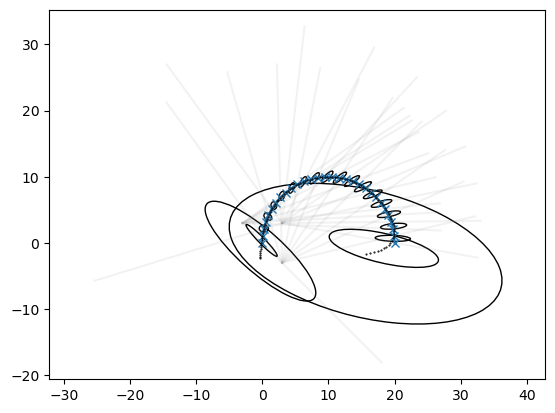

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.axis('equal')
plt.plot(true_locations[:,0],true_locations[:,1],'x-')
plt.axis('equal')
for obs in observations:
    plt.plot([obs[0],obs[0]+obs[3]*30],[obs[1],obs[1]+obs[4]*30],color='grey',alpha=0.1)

ax = plt.gca()
for i,(m,c) in enumerate(zip(M.numpy(),C.numpy())):
    std = max(np.sqrt(c[0,0]),np.sqrt(c[1,1]))
    plt.plot(m[0],m[1],'.k',markersize=1)

    if i%5==0:
        el = confidence_ellipse(m[:2],c[:2,:2],ax)
        ax.add_patch(el)

plt.show()

We have a quick reversion back to the origin (due to the short lengthscale).